In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [2]:
# Load Data
pokemon_df = pd.read_csv("../data/pokemon.csv")
combats_df = pd.read_csv("../data/combats.csv")

# Rename and index for merging
pokemon_df.rename(columns={"#": "ID"}, inplace=True)

In [3]:
# Add Base Stat Total (BST)
pokemon_df["BST"] = pokemon_df[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].sum(axis=1)
pokemon_df = pokemon_df.set_index("ID")
pokemon_df.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,BST
ID,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,309


In [4]:
# Merge Combat Data with Pokémon Stats including BST
def get_features(row):
    p1 = pokemon_df.loc[row["First_pokemon"]]
    p2 = pokemon_df.loc[row["Second_pokemon"]]
    features = (
        p1[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].tolist() +
        p2[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].tolist() +
        [p1["BST"], p2["BST"]]
    )
    return pd.Series(features)

feature_df = combats_df.apply(get_features, axis=1)
feature_df.columns = [
    "P1_HP", "P1_Atk", "P1_Def", "P1_SpAtk", "P1_SpDef", "P1_Spd",
    "P2_HP", "P2_Atk", "P2_Def", "P2_SpAtk", "P2_SpDef", "P2_Spd",
    "P1_BST", "P2_BST"
]

# Add target label
feature_df["Winner"] = combats_df["Winner"]
feature_df["Label"] = (feature_df["Winner"] == combats_df["First_pokemon"]).astype(int)

feature_df.head()

,P1_HP,P1_Atk,P1_Def,P1_SpAtk,P1_SpDef,P1_Spd,P2_HP,P2_Atk,P2_Def,P2_SpAtk,P2_SpDef,P2_Spd,P1_BST,P2_BST,Winner,Label
0,50,64,50,45,50,41,70,70,40,60,40,60,300,340,298,0
1,91,90,72,90,129,108,91,129,90,72,90,108,580,580,701,0
2,55,40,85,80,105,40,75,75,75,125,95,40,405,485,668,0
3,40,40,40,70,40,20,77,120,90,60,90,48,250,485,683,0
4,70,60,125,115,70,55,20,10,230,10,230,5,495,505,151,1


In [5]:
# Add Differential Features
feature_df["HP_Diff"] = feature_df["P1_HP"] - feature_df["P2_HP"]
feature_df["Atk_Def_Diff"] = feature_df["P1_Atk"] - feature_df["P2_Def"]
feature_df["SpAtk_SpDef_Diff"] = feature_df["P1_SpAtk"] - feature_df["P2_SpDef"]
feature_df["SpDef_SpAtk_Diff"] = feature_df["P1_SpDef"] - feature_df["P2_SpAtk"]
feature_df["Speed_Diff"] = feature_df["P1_Spd"] - feature_df["P2_Spd"]
feature_df["BST_Diff"] = feature_df["P1_BST"] - feature_df["P2_BST"]

In [6]:
# Balance Dataset by Equalizing Win Labels

# Check initial label distribution
print("Original Win Distribution:")
print(feature_df["Label"].value_counts())

# Separate wins for Player 1 and Player 2
p1_wins = feature_df[feature_df["Label"] == 1]
p2_wins = feature_df[feature_df["Label"] == 0]

# Get the smaller class size
min_len = min(len(p1_wins), len(p2_wins))

# Sample equal amounts from both classes
balanced_df = pd.concat([
    p1_wins.sample(min_len, random_state=42),
    p2_wins.sample(min_len, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm new distribution
print("Balanced Win Distribution:")
print(balanced_df["Label"].value_counts())


Original Win Distribution:
Label
0    26399
1    23601
Name: count, dtype: int64
Balanced Win Distribution:
Label
1    23601
0    23601
Name: count, dtype: int64


In [7]:
# Preprocessing
X = balanced_df.drop(columns=["Winner", "Label"])
y = balanced_df["Label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4720
           1       0.90      0.89      0.89      4721

    accuracy                           0.89      9441
   macro avg       0.89      0.89      0.89      9441
weighted avg       0.89      0.89      0.89      9441



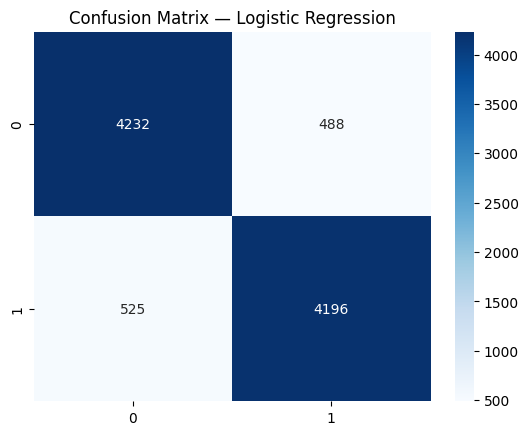

In [8]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

Random Forest Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4720
           1       0.95      0.96      0.95      4721

    accuracy                           0.95      9441
   macro avg       0.95      0.95      0.95      9441
weighted avg       0.95      0.95      0.95      9441



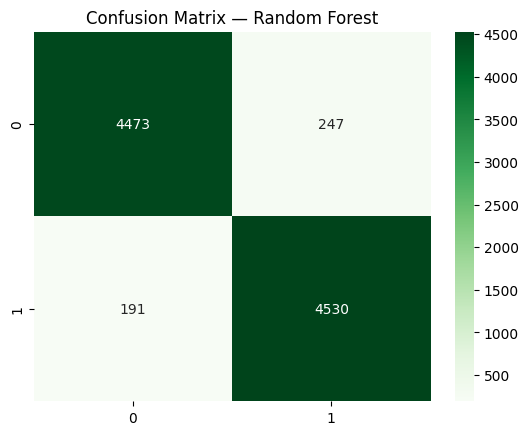

In [9]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest")
plt.show()

In [10]:
# Save the best model + scaler
joblib.dump(rf, "../models/model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
print("Model and scaler saved.")


Model and scaler saved.
